In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as tck
import json

import os
import re

from typing import List, Dict, Union, Tuple

from pyxyz import H2KC

from functools import reduce

from sklearn.decomposition import PCA

In [2]:
class DBSCAN:
    
    def __init__(
        self,
        eps : float = 0.5,
        min_pts : int = 3,
        period : float = 2*np.pi
    ):
        """
            Simple DBSCAN algo
        """
        
        self.eps = eps
        self.min_pts = min_pts
        self.num_of_clusters = 0
        self.period = period
        
    def euclidean_dist(
        self, 
        a : np.ndarray, 
        b : np.ndarray
    ) -> float:
        return np.sqrt((a - b).dot(a - b))

    def max_angle_diff_dist(
        self, 
        a : np.ndarray, 
        b : np.ndarray
    ) -> float:
        dists = np.abs(a - b) % self.period
        return np.max(
            np.min(
                [dists, self.period-dists],
                axis=0
            )
        )
        
    def fit_predict(
        self, 
        X : np.ndarray
    ) -> np.ndarray:
        """
            Performs DBSCAN algorithm, returns labels for each point from X
        """
        self.labels_ = -np.ones(X.shape[0], int)
        
        # Iterate through all points
        for i in range(X.shape[0]):
            if self.labels_[i] != -1:
                continue
            # Find neighbors in 'eps'     
            neighbors = []
            for j in range(X.shape[0]):
                if i == j:
                    continue
                if self.max_angle_diff_dist(X[i], X[j]) <= self.eps:
                    neighbors.append(j)
                    
            if (len(neighbors) + 1) < self.min_pts:
                continue
            self.labels_[i] = self.num_of_clusters
            for j in neighbors:
                if self.labels_[j] != -1:
                    continue
                self.labels_[j] = self.num_of_clusters
                new_neighbors = []
                for k in range(X.shape[0]):
                    if k == j:
                        continue
                    if self.max_angle_diff_dist(X[j], X[k]) <= self.eps:
                        new_neighbors.append(k)
                if (len(new_neighbors) + 1) >= self.min_pts:
                    neighbors.extend(new_neighbors)
            self.num_of_clusters += 1
            
        return self.labels_

In [3]:
class BaseExperiment:
    def __init__(
        self,
    ) -> None:
        
        self.clustering_params = {'eps' : np.pi/12, 'min_pts' : 1}

    def get_lowest_occurred_energy(
        self
    ) -> float:
        """
            Returns lowest located in experiment energy
        """
        raise NotImplementedError

    def get_25th_percentile(
        self
    ) -> float:
        raise NotImplementedError

    def get_10th_percentile(
        self
    ) -> float:
        raise NotImplementedError

    def get_mean_ensemble_pairwise_rmsd(
        self
    ) -> float:
        raise NotImplementedError

    def get_num_of_minima_clusters(
        self,
    ) -> None:
        raise NotImplementedError

In [4]:
class Experiment(BaseExperiment):
    def __init__(
        self,
        exp_name : str,
        minima : List[Tuple[List[float], float]],
        norm_en_table_filename : str = 'logs/bocs_norm_en.csv',
        energy_threshold : float = 3.,
        clustering_params : Union[Dict[str, Union[int, float]], None] = None,
    ) -> None:
        self.minima = minima
        
        self.exp_name = exp_name
        self.norm_ens = pd.read_csv(norm_en_table_filename).rename(columns={"Unnamed: 1": "norm_en"})   
        self.energy_threshold = energy_threshold

        self.minima_points = [cur[1] for cur in self.minima]

        if clustering_params:        
            self.clustering_params = clustering_params
        
        self.logs = json.load(open(f"logs/{exp_name}_logs.json", "r"))
        self.all_points = json.load(open(f"logs/{exp_name}_all_points.json", "r"))
        
        if (self.norm_ens.exp_name == exp_name).sum() != 0:
             self.norm_en = self.norm_ens[self.norm_ens.exp_name == exp_name].norm_en.to_numpy()[0]
        else:
            self.norm_en = self.logs['norm_en'] 

        self.point_labels = None

    def get_lowest_occurred_energy(
        self
    ) -> float:
        """
            Returns lowest located in experiment energy
        """
        assert np.min(self.all_points['observations']) == np.min(self.minima_points), f"{np.min(self.all_points['observations'])}, {np.min(self.minima_points)}"
        return self.norm_en + np.min(self.all_points['observations'])

    def get_25th_percentile(
        self
    ) -> float:
        return self.norm_en + np.quantile(self.minima_points, q=0.25)

    def get_10th_percentile(
        self
    ) -> float:
        return self.norm_en + np.quantile(self.minima_points, q=0.1)

    def get_mean_ensemble_pairwise_rmsd(
        self
    ) -> float:
        current_en_threshold = np.min(self.minima_points) + self.energy_threshold
        ensemble_coords = []
        for node_coords, node_en in self.minima:
            if node_en <= current_en_threshold:
                ensemble_coords.append(node_coords)
        ensemble_coords = np.asarray(ensemble_coords)

        dists = (ensemble_coords[np.newaxis, :, :] - ensemble_coords[:, np.newaxis, :])**2

        return np.mean(np.sqrt(dists.sum(axis=-1)))

    def get_lowest_energy_occurrence_step(
        self
    ) -> int:
        cur_en = np.inf
        cur_step = 0
        for idx, en in enumerate(self.logs['deepest_minima']):
            if en < cur_en:
                cur_en = en
                cur_step = idx + 1
        return cur_step

    def _filter_points(
        self
    ) -> List[int]:
        """
            Return idxs of points, that has energies less or equal then (min_energy + self.energy_threshold) 
        """

        idxs = []
        border = np.min(self.all_points['observations']) + self.energy_threshold
        for idx, cur_energy in enumerate(self.all_points['observations']):
            if cur_energy <= border:
                idxs.append(idx)
        return idxs
    
    def get_num_of_clusters(
        self,
    ) -> int:
        """
            Performs DBSCAN clustering on filtered points
        """
        filtered_idxs = self._filter_points()
        filtered_points = np.asarray(self.all_points['query_points'])[filtered_idxs, :]

        clustering_results = DBSCAN(**self.clustering_params).fit_predict(
            filtered_points
        )
        
        return np.unique(clustering_results).shape[0]

    def get_num_of_minima_clusters(
        self,
    ) -> int:
        current_en_threshold = np.min(self.minima_points) + self.energy_threshold
        ensemble_coords = []
        for node_coords, node_en in self.minima:
            if node_en <= current_en_threshold:
                ensemble_coords.append(node_coords)
        ensemble_coords = np.asarray(ensemble_coords)
        
        clustering_results = DBSCAN(**self.clustering_params).fit_predict(
            ensemble_coords
        )
        
        return np.unique(clustering_results).shape[0]

    def get_mean_clusterized_ensemble_pairwise_rmsd(
        self,
    ) -> float:
        current_en_threshold = np.min(self.minima_points) + self.energy_threshold
        ensemble_coords = []
        ensemble_ens = []
        for node_coords, node_en in self.minima:
            if node_en <= current_en_threshold:
                ensemble_coords.append(node_coords)
                ensemble_ens.append(node_en)
        ensemble_coords = np.asarray(ensemble_coords)
        ensemble_ens = np.asarray(ensemble_ens)

        clustering_results = DBSCAN(**self.clustering_params).fit_predict(
            ensemble_coords
        )

        clustered_ens_idxs = {
            cluster_idx: -1 for cluster_idx in np.unique(clustering_results)
        }

        for idx, cluster_idx in enumerate(clustering_results):
            if clustered_ens_idxs[cluster_idx] == -1:
                clustered_ens_idxs[cluster_idx] = idx
            if ensemble_ens[idx] < ensemble_ens[clustered_ens_idxs[cluster_idx]]:
                clustered_ens_idxs[cluster_idx] = idx

        clustered_ensemble_coords = ensemble_coords[list(clustered_ens_idxs.values())]

        dists = (clustered_ensemble_coords[np.newaxis, :, :] - clustered_ensemble_coords[:, np.newaxis, :])**2

        return np.mean(np.sqrt(dists.sum(axis=-1)))

    def get_clusterized_energies(
        self
    ) -> List[float]:
        current_en_threshold = np.min(self.minima_points) + self.energy_threshold
        ensemble_coords = []
        ensemble_ens = []
        for node_coords, node_en in self.minima:
            if node_en <= current_en_threshold:
                ensemble_coords.append(node_coords)
                ensemble_ens.append(node_en)
        ensemble_coords = np.asarray(ensemble_coords)
        ensemble_ens = np.asarray(ensemble_ens)

        clustering_results = DBSCAN(**self.clustering_params).fit_predict(
            ensemble_coords
        )

        clustered_ens_idxs = {
            cluster_idx: -1 for cluster_idx in np.unique(clustering_results)
        }

        for idx, cluster_idx in enumerate(clustering_results):
            if clustered_ens_idxs[cluster_idx] == -1:
                clustered_ens_idxs[cluster_idx] = idx
            if ensemble_ens[idx] < ensemble_ens[clustered_ens_idxs[cluster_idx]]:
                clustered_ens_idxs[cluster_idx] = idx
        return (ensemble_ens[list(clustered_ens_idxs.values())] + self.norm_en).tolist()

    def get_clusterized_coords(
        self
    ) -> List[List[float]]:
        current_en_threshold = np.min(self.minima_points) + self.energy_threshold
        ensemble_coords = []
        ensemble_ens = []
        for node_coords, node_en in self.minima:
            if node_en <= current_en_threshold:
                ensemble_coords.append(node_coords)
                ensemble_ens.append(node_en)
        ensemble_coords = np.asarray(ensemble_coords)
        ensemble_ens = np.asarray(ensemble_ens)

        clustering_results = DBSCAN(**self.clustering_params).fit_predict(
            ensemble_coords
        )

        clustered_ens_idxs = {
            cluster_idx: -1 for cluster_idx in np.unique(clustering_results)
        }

        for idx, cluster_idx in enumerate(clustering_results):
            if clustered_ens_idxs[cluster_idx] == -1:
                clustered_ens_idxs[cluster_idx] = idx
            if ensemble_ens[idx] < ensemble_ens[clustered_ens_idxs[cluster_idx]]:
                clustered_ens_idxs[cluster_idx] = idx
        return ensemble_coords[list(clustered_ens_idxs.values())].tolist()

In [5]:
class ExternalExperiment(BaseExperiment):
    def __init__(
        self,
        ens_xyz_filename : str,
        dihedral_idxs : List[List[int]]
    ) -> None:
        super().__init__()

        xyz_blocks = []
        
        current_block = ""
        with open(ens_xyz_filename) as file:
            for idx, line in enumerate(file):
                if len(line.split()) == 1 and idx > 0:
                    xyz_blocks.append(current_block)
                    current_block = ""
                current_block += line
            xyz_blocks.append(current_block)

        self.en = np.asarray([float(cur.split('\n')[1].split()[-1])*H2KC for cur in xyz_blocks])
        self.dihedral_coords = []

        for raw_xyz in xyz_blocks:
            coords = [list(map(float, cur.split()[1:])) for cur in raw_xyz.split('\n')[2:]]
            if len(coords[-1]) == 0:
                coords.pop()
            dihedrals = []
            for i, j, k, l in dihedral_idxs:
                dihedrals.append(
                    self.dihedral_angle(
                        coords[i], coords[j], coords[k], coords[l]
                    )
                )
            self.dihedral_coords.append(dihedrals)

    def dihedral_angle(self, a : list[float], b : list[float], c : list[float], d : list[float]) -> float:
        """
           Calculates dihedral angel between 4 points
        """
        
        a = np.array(a)
        b = np.array(b)
        c = np.array(c)
        d = np.array(d)
        
        #Next will be calc of signed dihedral angel in terms of rdkit
        #Vars named like in rdkit source code
    
        lengthSq = lambda u : np.sum(u ** 2)
        
        nIJK = np.cross(b - a, c - b)
        nJKL = np.cross(c - b, d - c)
        m = np.cross(nIJK, c - b)
    
        res =  -np.arctan2(np.dot(m, nJKL) / np.sqrt(lengthSq(m) * lengthSq(nJKL)),\
                           np.dot(nIJK, nJKL) / np.sqrt(lengthSq(nIJK) * lengthSq(nJKL)))
        return (res + 2 * np.pi) % (2 * np.pi)

    def get_lowest_occurred_energy(
        self
    ) -> float:
        """
            Returns lowest located in experiment energy
        """
        return np.min(self.en)

    def get_25th_percentile(
        self
    ) -> float:
        return np.quantile(self.en, q=0.25)

    def get_10th_percentile(
        self
    ) -> float:
        return np.quantile(self.en, q=0.1)

    def get_mean_ensemble_pairwise_rmsd(
        self
    ) -> float:

        ensemble_coords = np.asarray(self.dihedral_coords)

        dists = (ensemble_coords[np.newaxis, :, :] - ensemble_coords[:, np.newaxis, :])**2

        return np.mean(np.sqrt(dists.sum(axis=-1)))
    
    def get_num_of_minima_clusters(
        self,
    ) -> None:

        ensemble_coords = np.asarray(self.dihedral_coords)
        
        clustering_results = DBSCAN(**self.clustering_params).fit_predict(
            ensemble_coords
        )
        
        return np.unique(clustering_results).shape[0]

    def get_mean_clusterized_ensemble_pairwise_rmsd(
        self,
    ) -> float:

        ensemble_coords = np.asarray(self.dihedral_coords)

        clustering_results = DBSCAN(**self.clustering_params).fit_predict(
            ensemble_coords
        )

        clustered_ens_idxs = {
            cluster_idx: -1 for cluster_idx in np.unique(clustering_results)
        }

        for idx, cluster_idx in enumerate(clustering_results):
            if clustered_ens_idxs[cluster_idx] == -1:
                clustered_ens_idxs[cluster_idx] = idx
            if self.en[idx] < self.en[clustered_ens_idxs[cluster_idx]]:
                clustered_ens_idxs[cluster_idx] = idx

        clustered_ensemble_coords = ensemble_coords[list(clustered_ens_idxs.values())]

        dists = (clustered_ensemble_coords[np.newaxis, :, :] - clustered_ensemble_coords[:, np.newaxis, :])**2

        return np.mean(np.sqrt(dists.sum(axis=-1)))

    def get_clusterized_energies(
        self
    ) -> List[float]:
        ensemble_coords = np.asarray(self.dihedral_coords)

        clustering_results = DBSCAN(**self.clustering_params).fit_predict(
            ensemble_coords
        )

        clustered_ens_idxs = {
            cluster_idx: -1 for cluster_idx in np.unique(clustering_results)
        }

        for idx, cluster_idx in enumerate(clustering_results):
            if clustered_ens_idxs[cluster_idx] == -1:
                clustered_ens_idxs[cluster_idx] = idx
            if self.en[idx] < self.en[clustered_ens_idxs[cluster_idx]]:
                clustered_ens_idxs[cluster_idx] = idx
        return self.en[list(clustered_ens_idxs.values())].tolist()

    def get_clusterized_coords(
        self
    ) -> List[List[float]]:
        ensemble_coords = np.asarray(self.dihedral_coords)

        clustering_results = DBSCAN(**self.clustering_params).fit_predict(
            ensemble_coords
        )

        clustered_ens_idxs = {
            cluster_idx: -1 for cluster_idx in np.unique(clustering_results)
        }

        for idx, cluster_idx in enumerate(clustering_results):
            if clustered_ens_idxs[cluster_idx] == -1:
                clustered_ens_idxs[cluster_idx] = idx
            if self.en[idx] < self.en[clustered_ens_idxs[cluster_idx]]:
                clustered_ens_idxs[cluster_idx] = idx
        return ensemble_coords[list(clustered_ens_idxs.values())].tolist()

class RdKitExperiment(ExternalExperiment):
    pass

class CrestExperiment(ExternalExperiment):
    pass

In [6]:
dihedral_idxs = {
    'mol_0' : [[2, 0, 1, 12], [4, 2, 0, 1], [0, 1, 12, 13], [2, 4, 6, 7], [4, 6, 7, 8], [9, 8, 7, 6], [13, 12, 15, 16], [17, 16, 15, 12]],
    'mol_1' : [[2, 1, 0, 12], [1, 2, 3, 4], [1, 2, 9, 10], [3, 4, 6, 5]],
    'mol_12' : [[9, 2, 3, 0], [3, 2, 9, 5], [9, 5, 6, 1], [6, 5, 9, 2], [9, 7, 8, 4], [8, 7, 9, 2]],
    'mol_22' :  [[4, 3, 1, 0], [1, 3, 4, 5], [3, 4, 5, 6], [4, 5, 6, 7], [4, 5, 9, 10], [5, 9, 10, 13]],
    'mol_69' : [[4, 1, 2, 3], [5, 4, 1, 2], [6, 5, 4, 1], [4, 5, 6, 7], [5, 6, 7, 8]],
    'mol_80' : [[5, 3, 0, 1], [0, 3, 5, 7], [8, 7, 5, 3]],
    'mol_83' : [[1, 4, 6, 7], [4, 6, 7, 8]],
    'mol_110' : [[6, 3, 1, 0], [1, 3, 6, 9], [3, 6, 9, 10]],
    'mol_115' : [[0, 1, 2, 3], [4, 3, 2, 1], [2, 3, 4, 5], [3, 4, 5, 6], [7, 6, 5, 4], [5, 6, 7, 8], [6, 7, 8, 9], [10, 9, 8, 7]],
    'mol_129' : [[6, 3, 0, 2], [3, 6, 1, 4], [0, 3, 6, 1]]
}

In [7]:
class StatAgregator:
    def __init__(
        self,
        exp_prefix : str,
        minima_data : Dict[str, List[Tuple[List[float], float]]],
        norm_en_table_filename : str = 'logs/bocs_norm_en.csv',
        clustering_params : Union[Dict[str, Union[int, float]], None] = None,
        whitelist : Union[None, List[str]] = None
    ) -> None:
        self.exp_prefix = exp_prefix
        self.minima_data = minima_data
        self.experiments = {
            'bocs' : [],
            'base' : []
        }
        for file in os.listdir("logs/"):
            if re.match(exp_prefix+"_bocs_\d+_all_points.json", file):
                exp_name = file[:-len("_all_points.json")]
                if exp_name in whitelist:
                    continue
                self.experiments['bocs'].append(
                    Experiment(
                        exp_name=exp_name,
                        minima=self.minima_data[exp_name],
                        norm_en_table_filename=norm_en_table_filename,
                        clustering_params=clustering_params
                    )
                )
        for file in os.listdir("logs/"):
            if re.match(exp_prefix+"_base_\d+_all_points.json", file):
                exp_name=file[:-len("_all_points.json")]
                if exp_name in whitelist:
                    continue
                self.experiments['base'].append(
                    Experiment(
                        exp_name=exp_name,
                        minima=self.minima_data[exp_name],
                        norm_en_table_filename=norm_en_table_filename,
                        clustering_params=clustering_params
                    )
                )
    def get_num_of_clusters(
        self
    ) -> Dict[str, List[int]]:
        return {
            'bocs' : [exp.get_num_of_clusters() for exp in self.experiments['bocs']],
            'base' : [exp.get_num_of_clusters() for exp in self.experiments['base']]
        }
        
    def get_num_of_minima_clusters(
        self
    ) -> Dict[str, List[int]]:
        return {
            'bocs' : [exp.get_num_of_minima_clusters() for exp in self.experiments['bocs']],
            'base' : [exp.get_num_of_minima_clusters() for exp in self.experiments['base']]
        }

    def get_lowest_energy_occurrence_steps(
        self
    ) -> Dict[str, List[int]]:
        return {
            'bocs' : [exp.get_lowest_energy_occurrence_step() for exp in self.experiments['bocs']],
            'base' : [exp.get_lowest_energy_occurrence_step() for exp in self.experiments['base']]
        }
    def get_lowest_energies(
        self
    ) -> Dict[str, List[float]]:
        bocs_energies = [exp.get_lowest_occurred_energy() for exp in self.experiments['bocs']]
        base_energies = [exp.get_lowest_occurred_energy() for exp in self.experiments['base']]
        
        min_en = min(bocs_energies + base_energies)
        
        bocs_energies = np.array(bocs_energies) - min_en
        base_energies = np.array(base_energies) - min_en

        return {
            'bocs' : bocs_energies.tolist(),
            'base' : base_energies.tolist()
        }

    def get_25th_percentiles(
        self
    ) -> Dict[str, List[float]]:
        bocs_energies = [exp.get_25th_percentile() for exp in self.experiments['bocs']]
        base_energies = [exp.get_25th_percentile() for exp in self.experiments['base']]
        
        min_en = min(bocs_energies + base_energies)
        
        bocs_energies = np.array(bocs_energies) - min_en
        base_energies = np.array(base_energies) - min_en

        return {
            'bocs' : bocs_energies.tolist(),
            'base' : base_energies.tolist()
        }

    def get_10th_percentiles(
        self
    ) -> Dict[str, List[float]]:
        bocs_energies = [exp.get_10th_percentile() for exp in self.experiments['bocs']]
        base_energies = [exp.get_10th_percentile() for exp in self.experiments['base']]
        
        min_en = min(bocs_energies + base_energies)
        
        bocs_energies = np.array(bocs_energies) - min_en
        base_energies = np.array(base_energies) - min_en

        return {
            'bocs' : bocs_energies.tolist(),
            'base' : base_energies.tolist()
        }

    def get_mean_ensemble_pairwise_rmsd(
        self
    ) -> Dict[str, List[float]]:
        return {
            'bocs' : [exp.get_mean_ensemble_pairwise_rmsd() for exp in self.experiments['bocs']],
            'base' : [exp.get_mean_ensemble_pairwise_rmsd() for exp in self.experiments['base']]
        }

    def get_mean_clusterized_ensemble_pairwise_rmsd(
        self,
    ) -> Dict[str, List[float]]:
        return {
            'bocs' : [exp.get_mean_clusterized_ensemble_pairwise_rmsd() for exp in self.experiments['bocs']],
            'base' : [exp.get_mean_clusterized_ensemble_pairwise_rmsd() for exp in self.experiments['base']]
        }

In [8]:
class CrossStatAgregator:
    def __init__(
        self,
        cross_exps : List[BaseExperiment],
        exp_prefix : str,
        minima_data : Dict[str, List[Tuple[List[float], float]]],
        norm_en_table_filename : str = 'logs/bocs_norm_en.csv',
        clustering_params : Union[Dict[str, Union[int, float]], None] = None,
        whitelist : Union[None, List[str]] = None
    ) -> None:
        self.exp_prefix = exp_prefix
        self.minima_data = minima_data
        self.experiments = {
            'bocs' : [],
            'opp' : cross_exps
        }
        for file in os.listdir("logs/"):
            if re.match(exp_prefix+"_bocs_\d+_all_points.json", file):
                exp_name = file[:-len("_all_points.json")]
                if exp_name in whitelist:
                    continue
                self.experiments['bocs'].append(
                    Experiment(
                        exp_name=exp_name,
                        minima=self.minima_data[exp_name],
                        norm_en_table_filename=norm_en_table_filename,
                        clustering_params=clustering_params
                    )
                )
        
    def get_num_of_minima_clusters(
        self
    ) -> Dict[str, List[int]]:
        return {
            'bocs' : [exp.get_num_of_minima_clusters() for exp in self.experiments['bocs']],
            'opp' : [exp.get_num_of_minima_clusters() for exp in self.experiments['opp']]
        }

    def get_lowest_energies(
        self
    ) -> Dict[str, List[float]]:
        bocs_energies = [exp.get_lowest_occurred_energy() for exp in self.experiments['bocs']]
        opp_energies = [exp.get_lowest_occurred_energy() for exp in self.experiments['opp']]
        
        min_en = min(bocs_energies + opp_energies)
        
        bocs_energies = np.array(bocs_energies) - min_en
        opp_energies = np.array(opp_energies) - min_en

        return {
            'bocs' : bocs_energies.tolist(),
            'opp' : opp_energies.tolist()
        }

    def get_25th_percentiles(
        self
    ) -> Dict[str, List[float]]:
        bocs_energies = [exp.get_25th_percentile() for exp in self.experiments['bocs']]
        opp_energies = [exp.get_25th_percentile() for exp in self.experiments['opp']]
        
        min_en = min(bocs_energies + opp_energies)
        
        bocs_energies = np.array(bocs_energies) - min_en
        opp_energies = np.array(base_energies) - min_en

        return {
            'bocs' : bocs_energies.tolist(),
            'opp' : opp_energies.tolist()
        }

    def get_10th_percentiles(
        self
    ) -> Dict[str, List[float]]:
        bocs_energies = [exp.get_10th_percentile() for exp in self.experiments['bocs']]
        opp_energies = [exp.get_10th_percentile() for exp in self.experiments['opp']]
        
        min_en = min(bocs_energies + opp_energies)
        
        bocs_energies = np.array(bocs_energies) - min_en
        opp_energies = np.array(base_energies) - min_en

        return {
            'bocs' : bocs_energies.tolist(),
            'opp' : opp_energies.tolist()
        }

    def get_mean_ensemble_pairwise_rmsd(
        self
    ) -> Dict[str, List[float]]:
        return {
            'bocs' : [exp.get_mean_ensemble_pairwise_rmsd() for exp in self.experiments['bocs']],
            'opp' : [exp.get_mean_ensemble_pairwise_rmsd() for exp in self.experiments['opp']]
        }
        
    def get_mean_clusterized_ensemble_pairwise_rmsd(
        self,
    ) -> Dict[str, List[float]]:
        return {
            'bocs' : [exp.get_mean_clusterized_ensemble_pairwise_rmsd() for exp in self.experiments['bocs']],
            'opp' : [exp.get_mean_clusterized_ensemble_pairwise_rmsd() for exp in self.experiments['opp']]
        }

In [11]:
exp_names = ['mol_0', 'mol_1', 'mol_12', 'mol_22', 'mol_69', 'mol_80', 'mol_83', 'mol_110', 'mol_115', 'mol_129']
exps = {
    exp : StatAgregator(
        minima_data=json.load(open('logs/collected_minima_final_full_full_full_full_revised.json', 'r')),
        exp_prefix=exp,
        clustering_params={
            'eps' : np.pi/12,
            'min_pts' : 1
        },
        whitelist=['mol_0_bocs_11', 'mol_129_bocs_9']
    ) for exp in exp_names
}

In [12]:
exp_names = ['mol_0', 'mol_1', 'mol_12', 'mol_22', 'mol_69', 'mol_80', 'mol_83', 'mol_110', 'mol_115', 'mol_129']
cross_exps = {
    exp : CrossStatAgregator(
        cross_exps=[
            CrestExperiment(
                ens_xyz_filename=f'logs/{exp}_full_ens_after_opt_fixed.xyz', 
                dihedral_idxs=dihedral_idxs[exp]
            )
        ] * 10,
        minima_data=json.load(open('logs/collected_minima_final_full_full_full_full_revised.json', 'r')),
        exp_prefix=exp,
        clustering_params={
            'eps' : np.pi/12,
            'min_pts' : 1
        },
        whitelist=['mol_0_bocs_11', 'mol_129_bocs_9']
    ) for exp in exp_names
}

In [13]:
exp_names = ['mol_0', 'mol_1', 'mol_12', 'mol_22', 'mol_69', 'mol_80', 'mol_83', 'mol_110', 'mol_115', 'mol_129']
cross_rdkit_exps = {
    exp : CrossStatAgregator(
        cross_exps=[
            CrestExperiment(
                ens_xyz_filename=f'logs/{exp}_final_fixed.xyz', 
                dihedral_idxs=dihedral_idxs[exp]
            )
        ] * 10,
        minima_data=json.load(open('logs/collected_minima_final_full_full_full_full_revised.json', 'r')),
        exp_prefix=exp,
        clustering_params={
            'eps' : np.pi/12,
            'min_pts' : 1
        },
        whitelist=['mol_0_bocs_11', 'mol_129_bocs_9']
    ) for exp in exp_names
}

In [14]:
coords = {'bocs' : {}, 'base' : {}, 'crest' : {}, 'rdkit' : {}}
ens = {'bocs' : {}, 'base' : {}, 'crest' : {}, 'rdkit' : {}}

In [ ]:
from tqdm import tqdm

for exp_name in tqdm(exps.keys()):
    cur_coords = []
    coords['bocs'][exp_name] = []
    for bocs_exp in exps[exp_name].experiments['bocs']:
        cur_coords.append(bocs_exp.get_clusterized_coords())
    coords['bocs'][exp_name] = cur_coords

    cur_coords = []
    coords['base'][exp_name] = []
    for base_exp in exps[exp_name].experiments['base']:
        cur_coords.append(bocs_exp.get_clusterized_coords())
    coords['base'][exp_name] = cur_coords

    coords['crest'][exp_name] = cross_exps[exp_name].experiments['opp'][0].get_clusterized_coords()
    coords['rdkit'][exp_name] = cross_rdkit_exps[exp_name].experiments['opp'][0].get_clusterized_coords()

 60%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 6/10 [00:02<00:01,  2.84it/s]

In [ ]:
from tqdm import tqdm

for exp_name in tqdm(exps.keys()):
    cur_ens = []
    ens['bocs'][exp_name] = []
    for bocs_exp in exps[exp_name].experiments['bocs']:
        cur_ens.append(bocs_exp.get_clusterized_energies())
    ens['bocs'][exp_name] = cur_ens

    cur_ens = []
    ens['base'][exp_name] = []
    for base_exp in exps[exp_name].experiments['base']:
        cur_ens.append(bocs_exp.get_clusterized_energies())
    ens['base'][exp_name] = cur_ens

    ens['crest'][exp_name] = cross_exps[exp_name].experiments['opp'][0].get_clusterized_energies()
    ens['rdkit'][exp_name] = cross_rdkit_exps[exp_name].experiments['opp'][0].get_clusterized_energies()

In [ ]:
coords_reduced = {
    method_name : {
        mol_name : np.asarray(reduce(lambda x, y: (x+y), cur_coords) if isinstance(cur_coords[0][0], list) else cur_coords)
        for mol_name, cur_coords in results.items()
    }
    for method_name, results in coords.items()
}

In [ ]:
ens_reduced = {
    method_name : {
        mol_name : np.asarray(reduce(lambda x, y: (x+y), cur_ens) if isinstance(cur_ens[0], list) else cur_ens)
        for mol_name, cur_ens in results.items()
    }
    for method_name, results in ens.items()
}

In [ ]:
plt.rcParams.update({'font.size': 24})

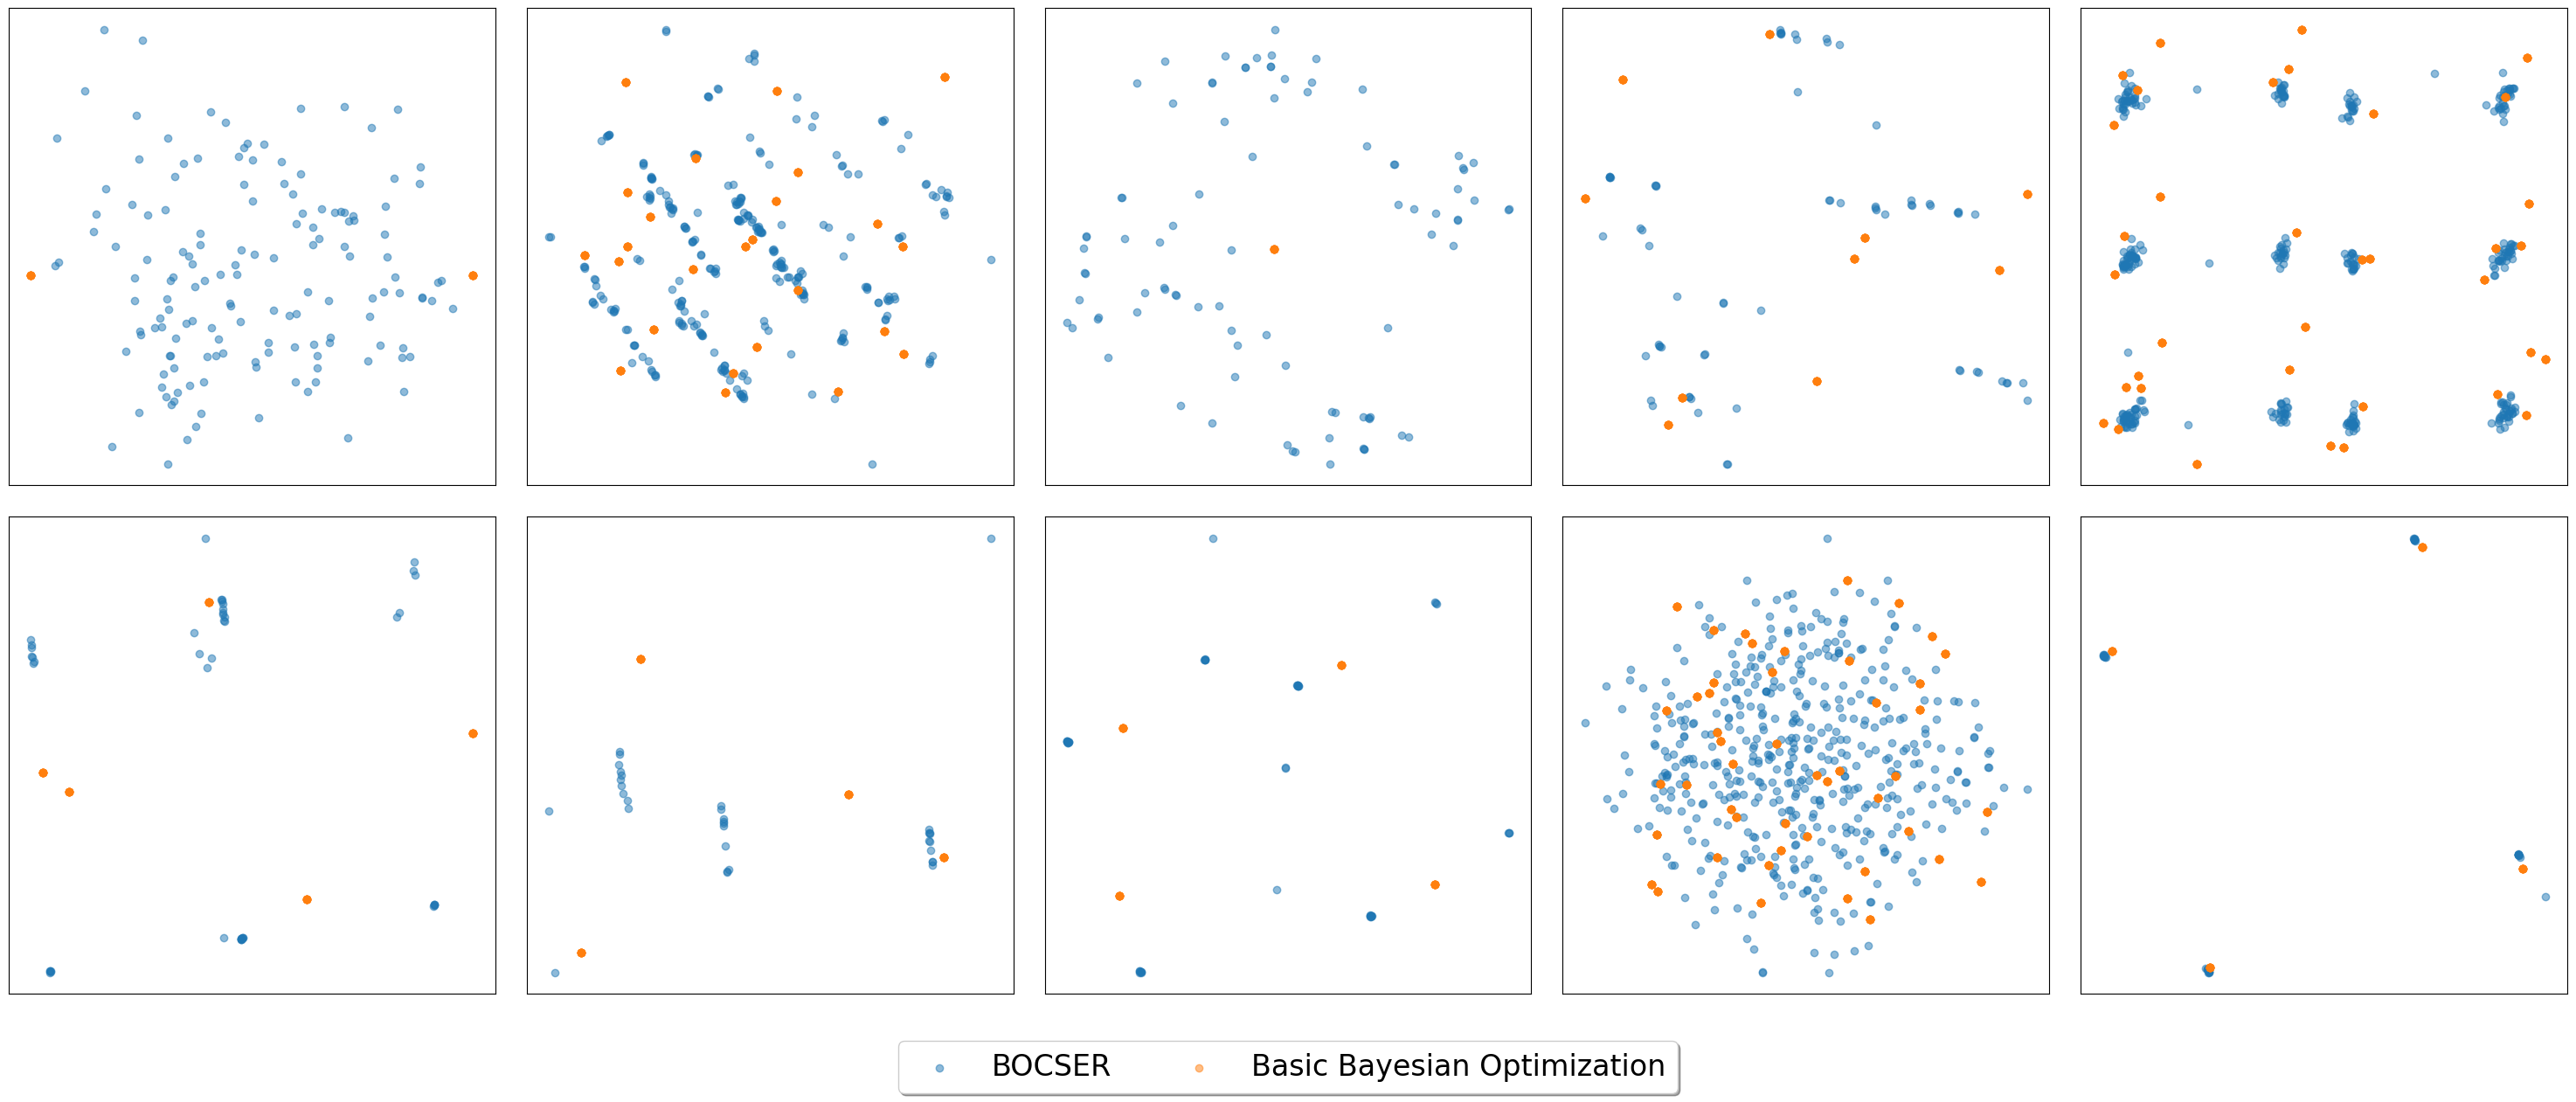

In [18]:
plt.figure(figsize=(30, 12))
for idx, mol_name in enumerate(exp_names):
    plt.subplot(2, 5, idx + 1)
    for method, results in coords_reduced.items():
        match method:
            case "rdkit" | "crest":
                continue
        current_reduced_coords = PCA(n_components=2).fit_transform(results[mol_name])
        plt.scatter(
            current_reduced_coords[:, 0], 
            current_reduced_coords[:, 1], 
            alpha=0.5, 
            label="BOCSER" if method == 'bocs' else "Basic Bayesian Optimization"
        )
        plt.xticks([])
        plt.yticks([])
       
plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(0, 0, 1, -0.001), fancybox=True, shadow=True, ncol=5, bbox_transform = plt.gcf().transFigure)

In [19]:
plt.rcParams.update({'font.size': 16})

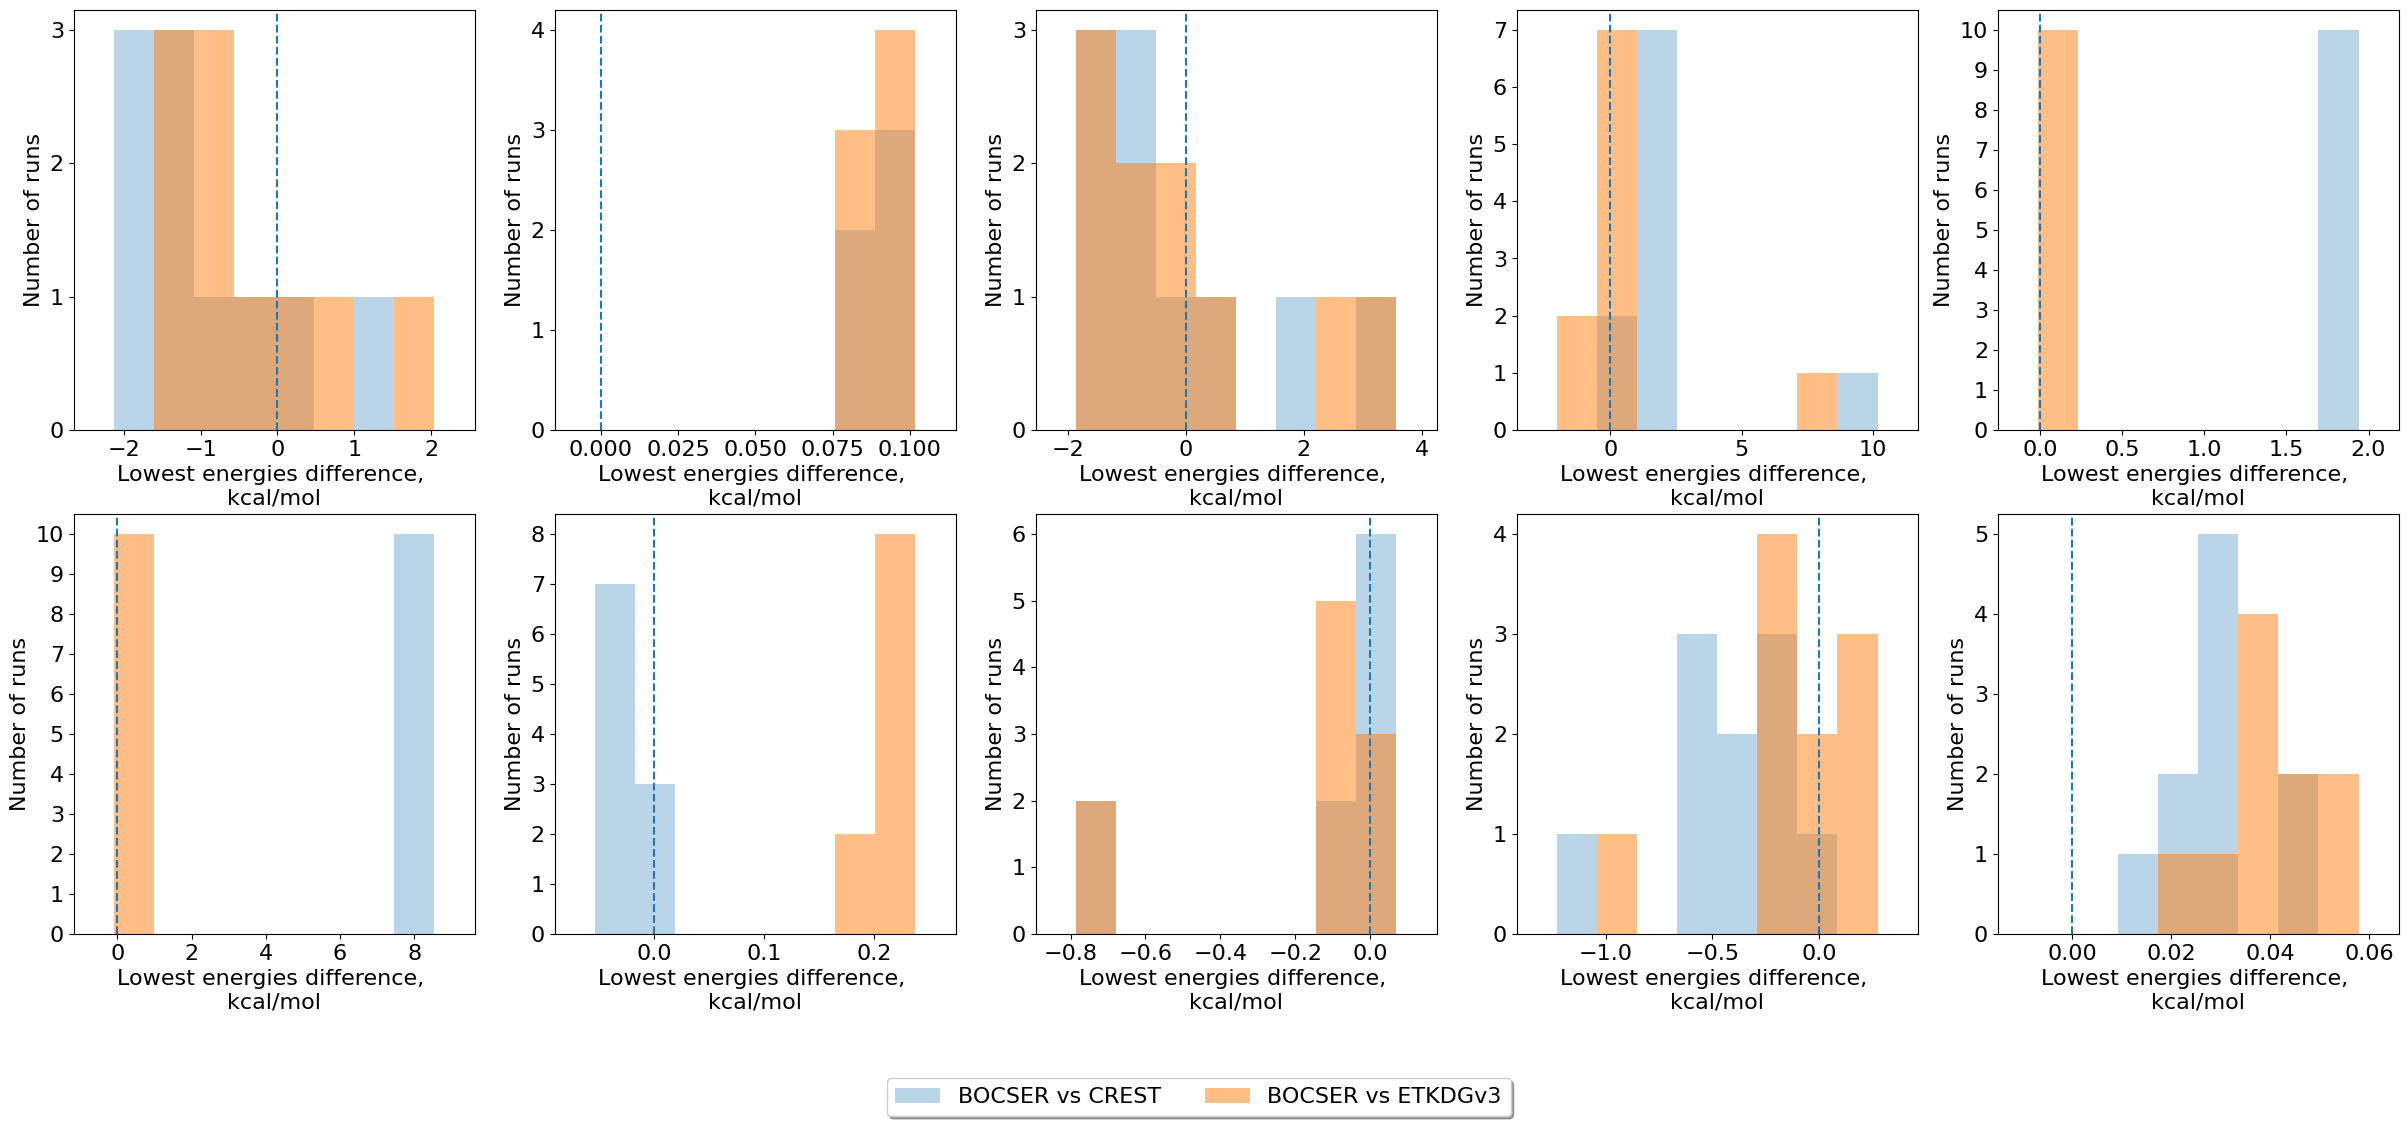

In [20]:
plt.figure(figsize=(30, 12))
for idx, exp_name in enumerate(exps.keys()):
    plt.subplot(2, 5, idx + 1)
    
    crest_diffs = []
    for bocs_en in cross_exps[exp_name].get_lowest_energies()['bocs']:
        crest_diffs.append(cross_exps[exp_name].get_lowest_energies()['opp'][0] - bocs_en)

    rdkit_diffs = []
    for bocs_en in cross_rdkit_exps[exp_name].get_lowest_energies()['bocs']:
        rdkit_diffs.append(cross_rdkit_exps[exp_name].get_lowest_energies()['opp'][0] - bocs_en)

    min_val, max_val = np.min(crest_diffs + rdkit_diffs), np.max(crest_diffs + rdkit_diffs)
    min_val -= (max_val - min_val) * 0.15
    max_val += (max_val - min_val) * 0.15

    min_val = min(-0.015, min_val)
    
    plt.hist(
        crest_diffs, 
        alpha=0.3, 
        label='BOCSER vs CREST', 
        bins=[min_val + idx*(max_val - min_val)/10 for idx in range(10)]
    )

    plt.hist(
        rdkit_diffs, 
        alpha=0.5, 
        label='BOCSER vs ETKDGv3', 
        bins=[min_val + idx*(max_val - min_val)/10 for idx in range(10)]
    )

    plt.axvline(0, linestyle='--')
    
    plt.xlim(min_val, max_val)

    plt.ylabel("Number of runs")
    plt.xlabel("Lowest energies difference, \nkcal/mol")

    plt.subplot(2, 5, idx + 1).yaxis.set_major_locator(tck.MultipleLocator())

plt.legend(loc='upper center', bbox_to_anchor=(0, 0, 1, -0.001), fancybox=True, shadow=True, ncol=5, bbox_transform = plt.gcf().transFigure)

Text(0, 0.5, 'Relative energy, kcal/mol')

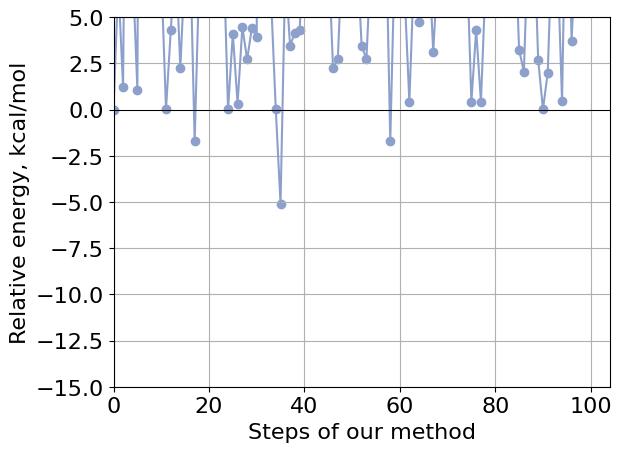

In [21]:
points = np.asarray(json.load(open('logs/mol_22_refinement_steps.json')))
points -= points[0]

points = points[points < 100]

plt.scatter(
    np.arange(points.shape[0]),
    points,
    alpha=1,
    color='#8da0cb'
)
plt.plot(
    np.arange(points.shape[0]),
    points,
    alpha=1,
    color='#8da0cb'
)

plt.grid()
plt.axhline(lw=0.75, color='k')
plt.xlim(0)
plt.ylim(-15, top=5)

plt.xlabel("Steps of our method")
plt.ylabel("Relative energy, kcal/mol")

Text(0, 0.5, 'Relative energy, kcal/mol')

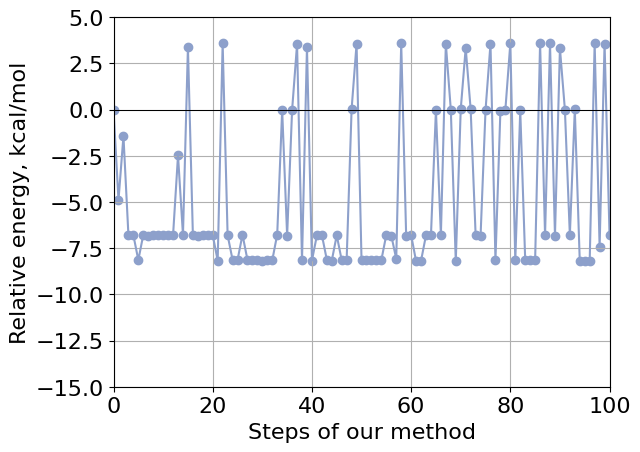

In [22]:
points = np.asarray(json.load(open('logs/mol_80_refinement_steps.json')))
points -= points[0]
plt.scatter(
    np.arange(points.shape[0]),
    points,
    alpha=1,
    color='#8da0cb'
)
plt.plot(
    np.arange(points.shape[0]),
    points,
    alpha=1.,
    color='#8da0cb'
)
plt.grid()
plt.axhline(lw=0.75, color='k')
plt.xlim(0, 100)
plt.ylim(-15, top=5)
plt.xlabel("Steps of our method")
plt.ylabel("Relative energy, kcal/mol")